<H1> Udacity Course in Self-driving: implementation of an algorithm to detect and track car positions </H1>

The first step is to import files. In the file <b>VDTlibrary.py</b> you will find a library developed for this issue.

In [38]:
from VDTlibrary import * # All functions are imported from VDTlibrary --> For more information see: VDTlibrary.ipynb
import numpy as np # Numpy package
import cv2 # OpenCV package 
import matplotlib.pyplot as plt # Plotting package
from scipy.ndimage.measurements import label # Label function
import cPickle as pickle # Saving and loading objects

print 'All packages loaded'

All packages loaded


The second step is <b>to define all the parameters</b> to use in the classification process

In [39]:
hist_bins = 32 # Defining the number of bins to use in the color histogram analysis
spatial_size = (32, 32) # The size of the image 
orient = 10 # Number of angle divisions to work with in HOG analysis
pix_per_cell = 8 # Number of pixels per cells 
cell_per_block = 2 # Number of cells per block
color_space = 'HSV' # Color space in which we are going to work
hog_channel = 'ALL' # Number of channels of the image to use in order to calculate the HOG
spatial_feat = True # This flag equal to True means that we are going to use the spatial features of the image
hist_feat = True # This flag equal to True means that we are going to use the color histogram features of the image
hog_feat = True # This flag equal to True means that we are going to use the HOG features of the image

print 'All variables loaded'

All variables loaded


<H2> Training process </H2>

Here you have two differents options:
   1. Load the classifier already trained by running the code below 
   2. Train the classifier running the code below 

In [40]:
# RUN THIS BLOCK IF YOU WANT TO USE THE PRE-TRAINED CLASSIFIER
fd = open('SVC-scaler.dat', 'rb') # Open the file with the SVC objects
clf_dictionary = pickle.load(fd) # Load the objects into a dictionary
fd.close() # Close the file
svc = clf_dictionary['svc-big'] # The classifier object
scaler = clf_dictionary['scaler-big'] # The scaler object

print 'SVC: ', svc
print 'Scaler: ', scaler

SVC:  LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=10000,
     multi_class='crammer_singer', penalty='l2', random_state=None,
     tol=0.0001, verbose=0)
Scaler:  StandardScaler(copy=True, with_mean=True, with_std=True)


Image file names loaded
Plotting some examples...


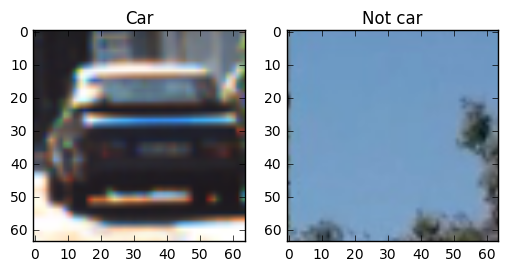

Extracting car features...
Car features extracted
Extracting not car features...
Not car features extracted
Normalising ...
Creating labels ...
Spliting and shuffle data set ...
Training process begins ...
(216.75, 'Seconds to train SVC...')
Training process is over !
Calculating accuracy ...
('Test Accuracy of SVC = ', 0.989)


In [41]:
# 1) Reading the car and not car images
cars, notcars = readimages('./big-set/', 'png')
print 'Image file names loaded'

# 1.1) Show a few samples of the dataset
print 'Plotting some examples...'
scar = mpimg.imread(cars[0])
sncar = mpimg.imread(notcars[0])
plt.figure()
plt.subplot(121)
plt.imshow(scar)
plt.title('Car')
plt.subplot(122)
plt.imshow(sncar)
plt.title('Not car')
plt.show()

# 2) Extraction of the features of the images
print 'Extracting car features...'
car_features = extract_features(cars, color_space = color_space, spatial_size = spatial_size,
                               hist_bins = hist_bins, orient = orient, pix_per_cell = pix_per_cell,
                               cell_per_block = cell_per_block, hog_channel = hog_channel, 
                               spatial_feat = spatial_feat, hist_feat = hist_feat, hog_feat = hog_feat)
print 'Car features extracted'
print 'Extracting not car features...'
notcar_features = extract_features(notcars, color_space = color_space, spatial_size = spatial_size,
                               hist_bins = hist_bins, orient = orient, pix_per_cell = pix_per_cell,
                               cell_per_block = cell_per_block, hog_channel = hog_channel, 
                               spatial_feat = spatial_feat, hist_feat = hist_feat, hog_feat = hog_feat)
print 'Not car features extracted'

# 3) Normalising the data 
print 'Normalising ...'
data, scaler = normalize(car_features, notcar_features)

# 4) Create a labeled vector 'y': 1 - car / 0 - not car
print 'Creating labels ...'
y = labeledvector(car_features, notcar_features)

# 5) Creating the training and validation sets
print 'Spliting and shuffle data set ...'
x_train, x_val, y_train, y_val = split_shuffle(data, y)

# 6) Create the classifier: SVC
svc = LinearSVC(multi_class = 'crammer_singer', max_iter = 10000)

# 7) Training the classifier
print 'Training process begins ...'
trainning(x_train, y_train, svc)
print 'Training process is over !'

# 8) Checking the accuracy of the classifier using the validation set
print 'Calculating accuracy ...'
accuracy(x_val, y_val, svc)

<H2> Processing class </H2>

Here we define a class called ProcessImage in which we have define all those functions needed to process and detect cars into a frame. The parameters of the class are:

- sampling_data: it is a matrix in which it is stored the start and stop positions and the windows size
- clf: classifier to use (SVC)
- scaler: the scaler to normalise the data
- overlap: the percentage of window overlaping 
- color_space: color space to use
- spatial_size: image shape
- hist_bins
- orient
- pix_per_cell
- cell_per_block
- hog_channel
- spatial_feat
- hist_feat
- hog_feat
    

In [42]:
class ProcessImage():
    
    def __init__(self, sampling_data, clf, scaler,
                       overlap, color_space, spatial_size, 
                       hist_bins, orient, pix_per_cell, 
                       cell_per_block, hog_channel, spatial_feat, 
                       hist_feat, hog_feat):
        self.sampling_data = sampling_data
        self.clf = clf
        self.scaler = scaler
        self.overlap = overlap
        self.color_space = color_space
        self.spatial_size = spatial_size
        self.hist_bins = hist_bins
        self.orient = orient
        self.pix_per_cell = pix_per_cell
        self.cell_per_block = cell_per_block
        self.hog_channel = hog_channel
        self.spatial_feat = spatial_feat
        self.hist_feat = hist_feat
        self.hog_feat = hog_feat
    
    #--------------------#
    def draw_heatmap(self, image, heatmap):
        #fig = plt.figure()
        plt.subplot(211)
        plt.imshow(image)
        plt.title('Car Positions')
        plt.subplot(212)
        plt.imshow(heatmap, cmap='hot')
        plt.title('Heat Map')
        #fig.tight_layout()
    
    #--------------------#
    def draw_detected_cars(self, image, labels, heatmap):
        draw_img = self.draw_labeled_bboxes(np.copy(image), labels)
        #fig = plt.figure()
        plt.subplot(211)
        plt.imshow(draw_img)
        plt.title('Car Positions')
        plt.subplot(212)
        plt.imshow(heatmap, cmap='hot')
        plt.title('Heat Map')
        #fig.tight_layout()
    
    #-------------------#
    # Define a function to draw bounding boxes
    def draw_boxes(self, img, bboxes, color=(0, 0, 255), thick=6):
        # Make a copy of the image
        imcopy = np.copy(img)
        # Iterate through the bounding boxes
        for bbox in bboxes:
            # Draw a rectangle given bbox coordinates
            cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
        # Return the image copy with boxes drawn
        return imcopy
        
    #-------------------#
    # Define a function to count the number of cars detected.
    def draw_labeled_bboxes(self, img, labels):
        # Iterate through all detected cars
        for car_number in range(1, labels[1]+1):
            # Find pixels with each car_number label value
            nonzero = (labels[0] == car_number).nonzero()
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Define a bounding box based on min/max x and y
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            # Draw the box on the image
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        # Return the image
        return img    
    
    #Function to detected cars#
    def car_zones(self, image, Hp):
        
        """
        Allow to get where car have been detected by using the function provided
        by Udacity SEARCH_WINDOWS.
        Input: - image
               - windows
        Return: - image with drawn boxes
                - detected boxes
        """
        # 1) Load data from the object
        windows_feat = self.sampling_data
        clf = self.clf
        scaler = self.scaler
        overlap = self.overlap
        color_space = self.color_space
        spatial_size = self.spatial_size
        hist_bins = self.hist_bins
        orient = self.orient
        pix_per_cell = self.pix_per_cell
        cell_per_block = self.cell_per_block
        hog_channel = self.hog_channel 
        spatial_feat = self.spatial_feat
        hist_feat = self.hist_feat 
        hog_feat = self.hog_feat
        
        # 2) Create a copy of the image
        cimage = np.copy (image)
        # 3) Create a empty list where to store the detected windows
        detected_windows_list = []
        # 4) Loop into the windows 
        for window_feat in windows_feat:
            # 4.1) Get the window using sliding_window
            windows = slide_window(image, x_start_stop=window_feat[0],
                                          y_start_stop=window_feat[1], 
                                          xy_window=window_feat[2], 
                                          xy_overlap=overlap)
            # 4.2) Get the local probabilities
            hp, hot_windows = search_windows(cimage, windows, clf, scaler, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat) 
            # 4.3) Store the probabilities into the Hp matrix
            Hp = add_probabilities(Hp, hp, windows)
            # 4.4) Store the detected boxes into the list
            detected_windows_list.extend(hot_windows)
            
        # 5) Return the detected windows and the probability matrix (Hp)
        return detected_windows_list, Hp
    
    #Function to process just one frame#
    def image_processing(self, img, Ht):
        # 1) Create two matrix in which we will store:
        Hc = np.zeros_like(img[:,:,0]).astype(np.float) # number of intersections per pixel
        Hp = np.zeros_like(img[:,:,0]).astype(np.float) # probability per pixel

        # 2) Rescale the image
        image = img.astype(np.float32)/255
        # 3) Get the detected boxes and the new probabilities
        detected_boxes, Hp = self.car_zones(image, Hp)
        # 4) Plot
        imgdetected = draw_boxes(image, detected_boxes)
        # 5) Normalize the probabilities --> Spatial probabilities
        Hc = calculate_intersections(Hc, detected_boxes)
        Hs = Hp/np.maximum(1, Hc)
        # 6) Check that probabilities are over a threshold
        # Get the Temporal probabilities --> Ht
        Ht = Hs * 0.5 + Ht * 0.5
        Ht[Ht < 0.4] = 0

        # 7) Draw the probabilities
        plt.subplot(221)
        plt.imshow(imgdetected)
        plt.title('Image')
        plt.subplot(222)
        plt.imshow(Hs)
        plt.title('Spatial probabilities')
        plt.subplot(223)
        plt.imshow(Ht)
        plt.title('Temporal probabilities')
        plt.pause(0.05)
        
        # 8) Return the detected boxes, the matrix of spatial and temporal probabilities 
        return detected_boxes, Hs, Ht
        
    def video_processing(self, video):
        
        # 1) Create a figure
        plt.figure()
        # 1.1) Enable the real-time plotting
        plt.ion()
        
        # 2) Get the object of cv2 to capture frame per frame
        cap = cv2.VideoCapture(video)
        
        # 3) Capture first-frame
        ret, frame = cap.read()
        
        # 4) Create a zero matrix of probabilities
        Ht = np.zeros_like(frame[:,:,0]).astype(np.float)
        
        # If you want to go to a specific zone of the video, uncommend this lines. I presupose that we have 25 fps
        #for _ in xrange(25*26):
        #    ret, frame = cap.read()
        
        while ret:
            # 5) Process each image from the video
            detected_boxes, Hs, Ht = self.image_processing(frame, Ht)
            
            # 6) Label Ht to remark the car zone as an unique square
            labels = label(Ht)
            
            # 7) Plot the new values
            plt.subplot(224)
            draw_detected_cars(frame, labels, Ht)
            
            # 8) Capture frame-by-frame
            ret, frame = cap.read()


<H2> Processing images </H2>

The <b>first thing</b> that we must do is to <b>create an object from class ProcessImage</b>. To do that step, we have to define to more parameters: 
- sampling_data
- overlap

In [43]:
sampling_data = [ #xstart  #xstop  #ystart  #ystop  #wxsize  #wysize
                [   [300, None],    [360,  None],    [128,  128]],
                [   [400, None],    [360,  600],     [96,  96]],
                [   [500, None],    [360,  560],     [80,  80]],
                [   [600, None],    [360,  500],     [64,  64]]]

# 75% of overlaping in x and y axis
overlap = (0.75, 0.75)

Now, once we have created the two parameters that are needed for the class ProcessImage, it is time to create the object.

In [44]:
prcimg = ProcessImage(sampling_data, svc, scaler, overlap, color_space, spatial_size, hist_bins, orient, pix_per_cell,
                     cell_per_block, hog_channel, spatial_feat, hist_feat, hog_feat)

So far, we have:
- Train a classifier: SVC
- Define a class to process the images
- and create an object of that class.

Therefore, the next step is to choose one video from the list above and execute the <i>video_processing</i> function. But firstly, let me explain you what you are going to see in you monitor when run the code below.

<H3> What does this class do? </H3>

When you are processing a video, you will have different image throught the time. Therefore, it is totally necessary to filter this efect by implementing a filter in which you take into acount:
- Current state
- Previous state
and promediate the effect of each one. How? By using the following equation:

<center> S<sub>t+1</sub> = S<sub>t</sub>P + S<sub>t-1</sub>(1-P)</center>

where S<sub>t+1</sub> is the next state, S<sub>t</sub> is the current one and S<sub>t-1</sub> the previous one, and P is the weight that will average the effect of falses positives in the current state with the previous one. 

In order to use what I have leant in this course, I have also implement a threshold, in which if the next state is over it will add its current value, but if it is not over it will add a 0. This technic allows us to deal with false positives, and joint together with the concept of heatmap learnt in this course. 

Moreover, the really new in the resolution here exposed is that we use instead of a heatmap, a probability map, what gives us very good results. We compute two different probabilities:
- Spatial: it means the probability of being a car. When you use sliding window technics you will have parts of the image in which you have intersections, and that means hot zones. If you compute the warm of the zone and the number of intersections in that zone, you will achieve the probability of being a car. In those zones in which there are a lot of intersections (and probably a car), the probability will be increased, just the opposite of those zones in which we have less intersections.
- Temporal: the equation shown above allow us to compute a temporal probability state, in which S<sub>t</sub> is the current spatial probability and S<sub>t-1</sub> the previous temporal probability. With this combination, we have into acount the previous state of the car, because it can occur that in one frame we 'loss' the car, but it is just an ilussion, because the car is still there.

Thanks to these probabilities, we can meake a better intersection of false positives, althought it is not enough as a consequence of the but results given by the classifier in those zones with shadows and threes. Here you can see an image in which you can compare our improvement by using this technic.

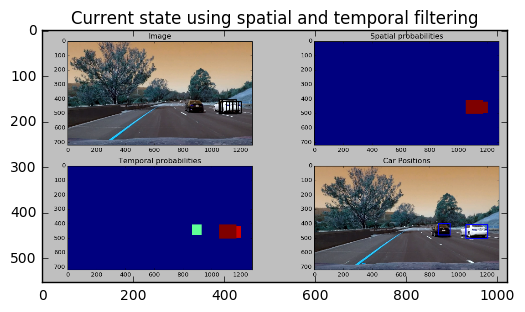

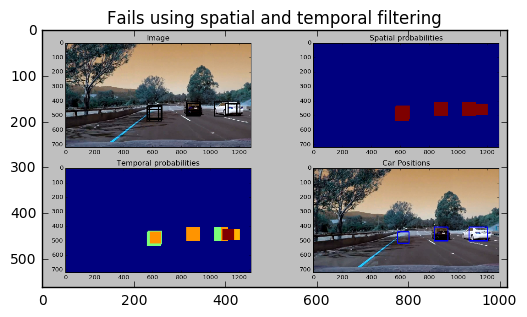

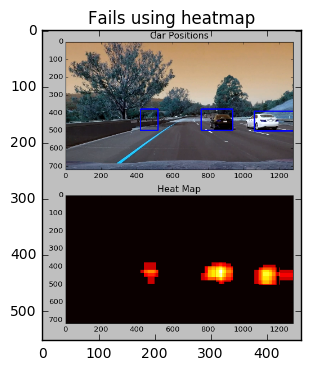

In [45]:
im1 = mpimg.imread('./img-pruebas/good.png')
im2 = mpimg.imread('./img-pruebas/fail.png')
im3 = mpimg.imread('./img-pruebas/manyfails.png')

plt.figure(1)
plt.imshow(im1)
plt.title('Current state using spatial and temporal filtering')
plt.figure(2)
plt.imshow(im2)
plt.title('Fails using spatial and temporal filtering')
plt.figure(3)
plt.imshow(im3)
plt.title('Fails using heatmap')
plt.show()


As you can see above, spatial and temporal filtering give us better results than the hetmap algorithm. Less errors, and normaly, when an error appear, next frame it is solved. That means, that in real life conditions we are not going to apreciate this errors because they will be caused in 1/fp seconds. Considering 25 fps, we are going to compute each 40 ms, a timelapse very assequible to assume this little errors perfectly.

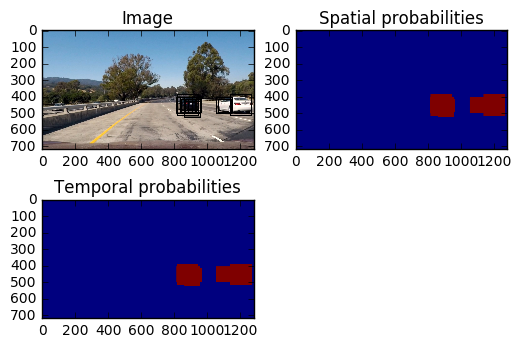

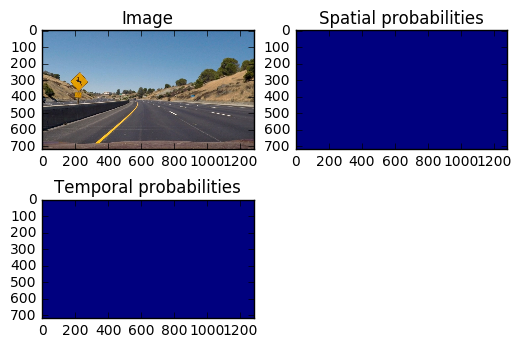

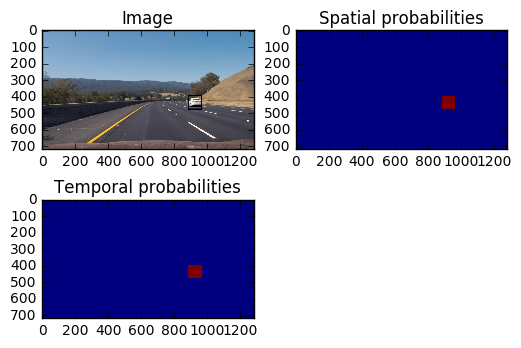

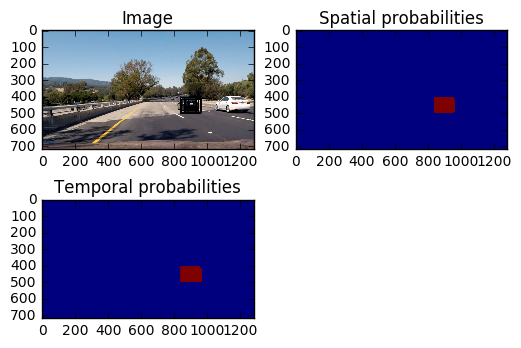

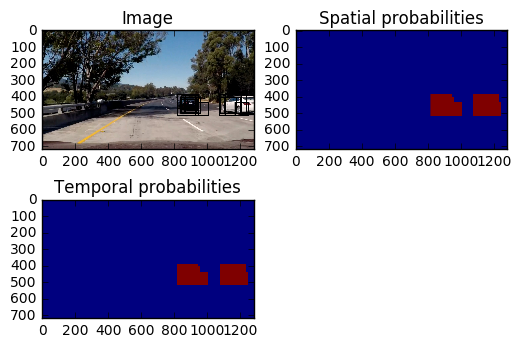

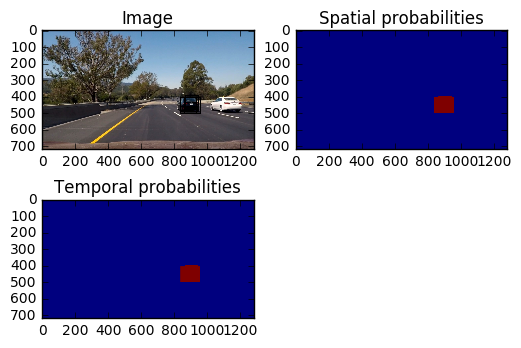

In [46]:
# Uncomment the video that you want to use. But right now, we are going to use it just with the images from test-set
#video = './test-images/test_video.mp4'
#video = './test-images/project_video.mp4'
#prcimg.video_processing(video)

# Read the name of every image in the path
images = glob.glob('./test-images/test*.jpg')

# Loop into the images read
for name in images:
    # Load the image
    image = mpimg.imread(name)
    # 4) Create a zero matrix of probabilities
    Ht = np.zeros_like(image[:,:,0]).astype(np.float)
    # Process the image
    plt.figure()
    prcimg.image_processing(image, Ht)
    plt.show()